In [1]:
!git clone https://github.com/mapooon/Face2Diffusion

Cloning into 'Face2Diffusion'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 47 (delta 13), reused 41 (delta 7), pack-reused 0
Receiving objects: 100% (47/47), 3.54 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
cd Face2Diffusion

/content/Face2Diffusion


In [3]:
!gdown https://drive.google.com/uc?id=1Lf_mwMgme_HVYJCkViGr4TfGOfKw9PhE -O checkpoints/mapping.pt
!gdown https://drive.google.com/uc?id=1DjUf-ib612SDDt86TRlsDkHqXTeYx030 -O checkpoints/msid.pt

Downloading...
From (original): https://drive.google.com/uc?id=1Lf_mwMgme_HVYJCkViGr4TfGOfKw9PhE
From (redirected): https://drive.google.com/uc?id=1Lf_mwMgme_HVYJCkViGr4TfGOfKw9PhE&confirm=t&uuid=d71e6ef6-3b03-4c4b-acda-1f0052994057
To: /content/Face2Diffusion/checkpoints/mapping.pt
100% 48.0M/48.0M [00:00<00:00, 129MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1DjUf-ib612SDDt86TRlsDkHqXTeYx030
From (redirected): https://drive.google.com/uc?id=1DjUf-ib612SDDt86TRlsDkHqXTeYx030&confirm=t&uuid=159d6140-cdec-4c34-b518-a3d7503efe3e
To: /content/Face2Diffusion/checkpoints/msid.pt
100% 85.9M/85.9M [00:01<00:00, 81.0MB/s]


In [5]:
!pip install diffusers transformers==4.30.2 face_alignment timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00


## Import modules

In [6]:
import os
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
import numpy as np
import cv2
from torch import nn
import argparse
import torchvision
import face_alignment
from PIL import Image
from torch.nn import functional as F
from src import modules
from src import utils
from src.msid import msid_base_patch8_112
from transformers.models.clip.modeling_clip import CLIPTextTransformer,CLIPTextModel
from src import mod

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Prepare Face2Diffusion Pipeline

In [7]:
assert torch.cuda.is_available() # you must use GPU e.g. T4
device = 'cuda'


pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16,safety_checker=None).to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

pipe.text_encoder.text_model.forward = mod.forward_texttransformer.__get__(pipe.text_encoder.text_model, CLIPTextTransformer)
pipe.text_encoder.forward = mod.forward_textmodel.__get__(pipe.text_encoder, CLIPTextModel)

img2text = modules.IMG2TEXTwithEXP(384*4,384*4,768)
img2text.load_state_dict(torch.load('checkpoints/mapping.pt',map_location='cpu'))
img2text=img2text.to(device)
img2text.eval()

msid = msid_base_patch8_112(ext_depthes=[2,5,8,11])
msid.load_state_dict(torch.load('checkpoints/msid.pt'))
msid=msid.to(device)
msid.eval()

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


MSIDEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        

# !!!Set input image and prompt!!!

In [8]:
input_prompt = 'f l eating bread in front of the Eiffel Tower' # You must input "f l" to represent the subject S*
guidance_scale = 10.0 # classifier-free guidance
n_samples = 8 # num of images to generate
img_path = 'input/0.jpg' # path to input image

## Tokenize input text

In [9]:
identifier='f'
ids = pipe.tokenizer(
                input_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=pipe.tokenizer.model_max_length,
            ).input_ids
placeholder_token_id=pipe.tokenizer(
                identifier,
                padding="do_not_pad",
                truncation=True,
                max_length=pipe.tokenizer.model_max_length,
            ).input_ids[1]
assert placeholder_token_id in ids,'identifier does not exist in prompt'
pos_id = ids.index(placeholder_token_id)

input_ids = pipe.tokenizer.pad(
        {"input_ids": [ids]},
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids

## encode input face and text

In [10]:
#identity encoding
detector=face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D,flip_input=False,device='cuda' if torch.cuda.is_available() else 'cpu')
lmk=np.array(detector.get_landmarks(img_path))[0]
img = np.array(Image.open(img_path).convert('RGB'))
with torch.no_grad():
    M=utils.align(lmk)
    img=utils.warp_img(img,M,(112,112))/255
    img=torch.tensor(img).permute(2,0,1).unsqueeze(0)
    img=(img-0.5)/0.5
    idvec = msid.extract_mlfeat(img.to(device).float(),[2,5,8,11])
    tokenized_identity_first, tokenized_identity_last = img2text(idvec,exp=None)
    hidden_states = utils.get_clip_hidden_states(input_ids.to(device),pipe.text_encoder).to(dtype=torch.float32)
    hidden_states[[0], [pos_id]]=tokenized_identity_first.to(dtype=torch.float32)
    hidden_states[[0], [pos_id+1]]=tokenized_identity_last.to(dtype=torch.float32)
    pos_eot = input_ids.to(dtype=torch.int, device=hidden_states.device).argmax(dim=-1)

#text encoding
with torch.autocast("cuda"):
    with torch.no_grad():
        encoder_hidden_states = pipe.text_encoder(hidden_states=hidden_states, pos_eot=pos_eot)[0]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:04<00:00, 19.3MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:05<00:00, 17.7MB/s]


## Generate images

  0%|          | 0/30 [00:00<?, ?it/s]

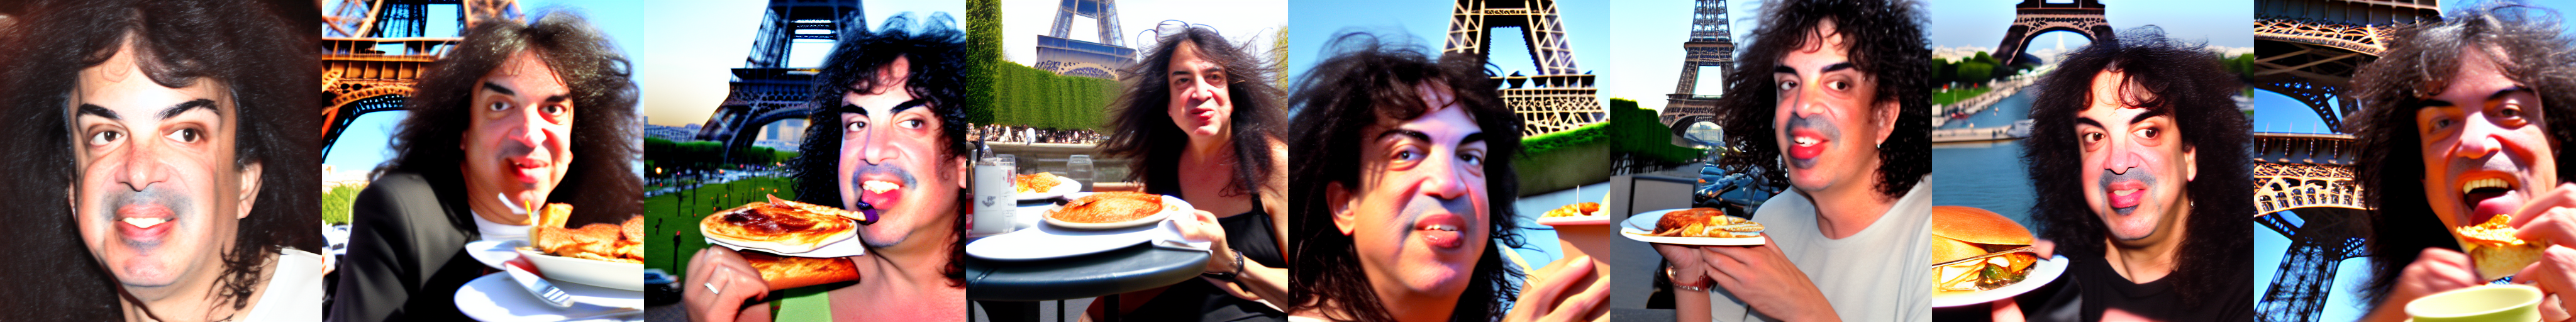

In [11]:
#diffusion process
generator = torch.Generator(device).manual_seed(0)
image = pipe(prompt_embeds=encoder_hidden_states, num_inference_steps=30, guidance_scale=guidance_scale,generator=generator,num_images_per_prompt=n_samples).images#[0]
image = np.concatenate([np.array(image[i]) for i in range(len(image))],1)
image = Image.fromarray(image.astype(np.uint8))

image